<h2><center>Detect diabetic retinopathy to stop blindness before it's too late</center></h2>
<center><img src="https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/APTOS%202019%20Blindness%20Detection/aux_img.png"></center>
##### Image source: http://cceyemd.com/diabetes-and-eye-exams/

In [27]:
!rm /kaggle/working/all_images/*

rm: cannot remove '/kaggle/working/all_images/*': No such file or directory


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Kích thước resize mong muốn
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

# Hàm crop ảnh (giữ lại vùng có nội dung)
def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:  # grayscale
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:  # RGB
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol        
        if mask.any():
            img1 = img[:,:,0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:,:,1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:,:,2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1,img2,img3], axis=-1)
        return img
    return img

# Hàm preprocess ảnh
def preprocess_image(image_path, sigmaX=10):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), sigmaX), -4, 128)        
    return cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # convert lại BGR để lưu

# Đường dẫn gốc
src1 = "/kaggle/input/aptos2019-blindness-detection/train_images"
src2 = "/kaggle/input/trainbylabel/train_by_label"
dst = "/kaggle/working/all_images"

os.makedirs(dst, exist_ok=True)

print("Preprocessing & saving images into:", dst)

# Copy và preprocess từ train_images
for file in tqdm(os.listdir(src1)):
    src_path = os.path.join(src1, file)
    dst_path = os.path.join(dst, file)
    if os.path.isfile(src_path):
        img = preprocess_image(src_path)
        cv2.imwrite(dst_path, img)

# Copy và preprocess từ train_by_label (bỏ qua class 0 và 2)
for root, _, files in os.walk(src2):
    if os.path.basename(root) in ["0", "2"]:
        continue
    for file in tqdm(files, desc=f"Processing {os.path.basename(root)}"):
        src_path = os.path.join(root, file)
        dst_path = os.path.join(dst, file)
        img = preprocess_image(src_path)
        cv2.imwrite(dst_path, img)

print(f"Tổng số ảnh trong {dst}:", len(os.listdir(dst)))


In [25]:
import os
import shutil

# Đường dẫn gốc
src1 = "/kaggle/input/aptos2019-blindness-detection/train_images"
src2 = "/kaggle/input/trainbylabel/train_by_label"
dst = "/kaggle/working/all_images"

os.makedirs(dst, exist_ok=True)

# Copy ảnh từ train_images
for file in os.listdir(src1):
    src_path = os.path.join(src1, file)
    dst_path = os.path.join(dst, file)
    if os.path.isfile(src_path):
        shutil.copy(src_path, dst_path)

# Copy ảnh từ train_by_label (bao gồm các thư mục con 0,1,2,3,4)
# Copy ảnh từ train_by_label (bỏ qua thư mục 0)
for root, _, files in os.walk(src2):
    # Nếu đường dẫn chứa /0 thì bỏ qua
    if os.path.basename(root) == "0":
        continue
    if os.path.basename(root) == "2":
        continue
    for file in files:
        src_path = os.path.join(root, file)
        dst_path = os.path.join(dst, file)
        shutil.copy(src_path, dst_path)

print(f"Tổng số ảnh trong {dst}:", len(os.listdir(dst)))


KeyboardInterrupt: 

In [3]:
# Helper libraries
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
%matplotlib inline
print(tensorflow.__version__)

2025-08-25 10:28:25.242096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756117705.448500    1479 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756117705.505899    1479 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.18.0


## Read in the training and test data

In [23]:
import os
import pandas as pd

# Đọc CSV nhãn
train_df = pd.read_csv('/kaggle/input/traincsv/train.csv')

# Thư mục chứa ảnh
img_dir = '/kaggle/input/pretrain/kaggle/working/all_images'

# Hàm tìm đúng file extension
def find_image_file(id_code):
    for ext in ['.png', '.jpeg', '.jpg']:
        path = os.path.join(img_dir, id_code + ext)
        if os.path.exists(path):
            return id_code + ext
    return None  # nếu không tìm thấy

# Tìm ảnh tương ứng và lọc bỏ ảnh không tồn tại
train_df['file_name'] = train_df['id_code'].apply(find_image_file)
train_df = train_df[train_df['file_name'].notnull()].reset_index(drop=True)

# --- GHÉP NHÃN ---
# gộp 3 (Severe) và 4 (Proliferative) thành 3
stage1_df = train_df.copy()
stage1_df['diagnosis'] = stage1_df['diagnosis'].replace({4: 3})
stage1_df['diagnosis'] = stage1_df['diagnosis'].astype(str)

print("Stage 1 label distribution:")
print(stage1_df['diagnosis'].value_counts())

stage2_df = train_df[train_df['diagnosis'].isin([3,4])].copy()
stage2_df['diagnosis'] = stage2_df['diagnosis'].astype(str)

print("Stage 2 label distribution:")
print(stage2_df['diagnosis'].value_counts())


# Áp dụng cho test
test_df = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/test.csv')
test_img_dir = '/kaggle/input/aptos2019-blindness-detection/test_images'
test_df['id_code'] = test_df['id_code'].apply(lambda x: x + '.png' if os.path.exists(os.path.join(test_img_dir, x + '.png')) 
                                              else x + '.jpeg')

# Số lớp mới và nhãn mô tả
num_classes = stage1_df['diagnosis'].nunique()
diag_text = ['Normal', 'Mild', 'Moderate', 'Severe/Proliferative']

print(f"Số lớp sau khi gộp: {num_classes}")
print(train_df.head())


Stage 1 label distribution:
diagnosis
3    2065
0    1796
1    1069
2     995
Name: count, dtype: int64
Stage 2 label distribution:
diagnosis
3    1062
4    1003
Name: count, dtype: int64
Số lớp sau khi gộp: 4
        id_code  diagnosis         file_name
0  000c1434d8d7          2  000c1434d8d7.png
1  001639a390f0          4  001639a390f0.png
2  0024cdab0c1e          1  0024cdab0c1e.png
3  002c21358ce6          0  002c21358ce6.png
4  005b95c28852          0  005b95c28852.png


### Look at some raw images

### Graph out the class frequency

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution(df, label_col="diagnosis", title="Class Frequency"):
    """
    Hiển thị số lượng ảnh theo từng nhãn trong dataframe.

    Args:
        df: pandas.DataFrame chứa dữ liệu
        label_col: tên cột chứa nhãn
        title: tiêu đề biểu đồ
    """
    unique, counts = np.unique(df[label_col], return_counts=True)
    
    for u, c in zip(unique, counts):
        print(f"Class {u}: {c} images")

    plt.bar(unique, counts)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.xticks(unique)  # đảm bảo hiển thị đúng nhãn
    plt.show()


Class 0: 1796 images
Class 1: 1069 images
Class 2: 995 images
Class 3: 1062 images
Class 4: 1003 images


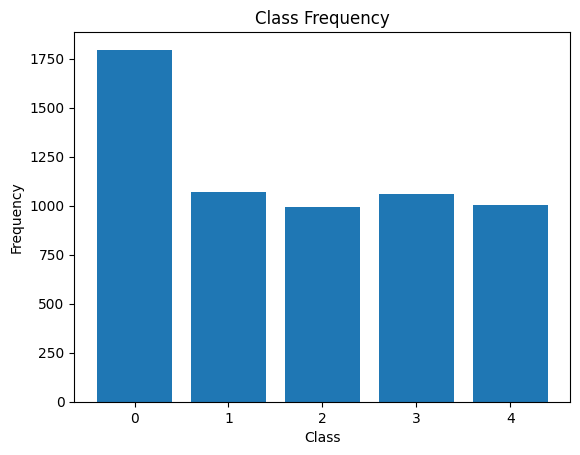

In [6]:
plot_class_distribution(train_df, label_col="diagnosis")


### Calculate class weights to help with training on the unbalanced data set.[](http://) 

In [19]:
from sklearn.utils import class_weight

classes = np.unique(stage1_df['diagnosis'])

sklearn_class_weights = class_weight.compute_class_weight(
    class_weight='balanced',   # ← tham số phải đặt tên
    classes=classes,
    y=stage1_df['diagnosis']
)

print(sklearn_class_weights)
class_weights_dict = dict(zip(classes, sklearn_class_weights))

[0.82 1.39 1.49 0.72]


## Load a model

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D ,Concatenate
from tensorflow.keras.applications import DenseNet121, ResNet50, InceptionV3, Xception, ResNet50V2, EfficientNetB4
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import layers, Model, Input
import tensorflow as tf

In [8]:
class CBAM(layers.Layer):
    def __init__(self, ratio=8, **kwargs):
        super(CBAM, self).__init__(**kwargs)
        self.ratio = ratio
        self.channel_dense1 = None
        self.channel_dense2 = None
        self.spatial_conv = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')

    def build(self, input_shape):
        channel = input_shape[-1]
        self.channel_dense1 = layers.Dense(channel // self.ratio, activation='relu', kernel_initializer='he_normal')
        self.channel_dense2 = layers.Dense(channel, kernel_initializer='he_normal')
        super(CBAM, self).build(input_shape)

    def call(self, x):
        # Channel attention
        avg_pool = tf.reduce_mean(x, axis=[1,2], keepdims=True)
        max_pool = tf.reduce_max(x, axis=[1,2], keepdims=True)
        avg_out = self.channel_dense2(self.channel_dense1(avg_pool))
        max_out = self.channel_dense2(self.channel_dense1(max_pool))
        scale = tf.nn.sigmoid(avg_out + max_out)
        x = x * scale

        # Spatial attention
        avg_pool_spatial = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_pool_spatial = tf.reduce_max(x, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool_spatial, max_pool_spatial], axis=-1)
        scale_spatial = self.spatial_conv(concat)
        x = x * scale_spatial
        return x

In [9]:


def create_resnet_effnet_cbam(input_shape, n_out):
    inputs = Input(shape=input_shape)

    # ResNet branch lấy feature map cuối cùng
    resnet_base = ResNet50V2(weights="imagenet", include_top=False, input_tensor=inputs)
    resnet_feat = resnet_base.get_layer("conv5_block3_out").output   # (7,7,2048)
    resnet_feat = CBAM(ratio=8)(resnet_feat)  # CBAM trên feature map

    # EfficientNet branch lấy feature map cuối cùng
    effnet_base = EfficientNetB4(weights="imagenet", include_top=False, input_tensor=inputs)
    effnet_feat = effnet_base.get_layer("top_conv").output           # (7,7,1792)
    effnet_feat = CBAM(ratio=8)(effnet_feat)

    # Gộp feature maps
    concat = Concatenate()([resnet_feat, effnet_feat])   # (7,7,2048+1792)

    # Global pooling
    gap = GlobalAveragePooling2D()(concat)
    x = Dropout(0.5)(gap)
    x = Dense(2048, activation = 'relu')(x)
    x = Dropout(0.5)(x)
    # Classifier
    outputs = Dense(n_out, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

def create_inception_v3_model(input_shape, n_out):
    base_model = InceptionV3(weights = None,
                             include_top = False,
                             input_shape = input_shape)
    base_model.load_weights('../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(2048, activation = 'relu'))
    model.add(Dropout(0.5))    
    model.add(Dense(n_out, activation = 'softmax'))
    return model

def create_xception_model(input_shape, n_out):
    base_model = Xception(weights = None,
                             include_top = False,
                             input_shape = input_shape)
    base_model.load_weights('../input/keras-pretrained-models/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(2048, activation = 'relu'))
    model.add(Dropout(0.5))    
    model.add(Dense(n_out, activation = 'sigmoid'))
    return model

def create_densenet121_model(input_shape, n_out):
    base_model = DenseNet121(weights = "imagenet",
                             include_top = False,
                             input_shape = input_shape)
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(2048, activation = 'relu'))
    model.add(Dropout(0.5))    
    model.add(Dense(n_out, activation = 'sigmoid'))
    return model

In [10]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
model = create_resnet_effnet_cbam(input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3), n_out = num_classes)
# model = create_densenet121_model(input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3), n_out = num_classes)

# IMAGE_HEIGHT = 299
# IMAGE_WIDTH = 299
# #model = create_inception_v3_model(input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3), n_out = num_classes)
# model = create_xception_model(input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3), n_out = num_classes)



I0000 00:00:1756118004.749004    1479 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [12]:
PRETRAINED_MODEL = '../input/pretrained_blindness_detector/blindness_detector.h5'

if (os.path.exists(PRETRAINED_MODEL)):
  print('Restoring model from ' + PRETRAINED_MODEL)
  model.load_weights(PRETRAINED_MODEL)
else:
  print('No pretrained model found. Using fresh model.')

current_epoch = 0

No pretrained model found. Using fresh model.


## Preprocess the data

#### Crop and improve lighting condition using Ben Graham's preprocessing method
See: https://www.kaggle.com/ratthachat/aptos-updated-preprocessing-ben-s-cropping

### Look at some preprocessed images

### Change target to a multi-label problem so a class encompasses all the classes before it.
see: https://arxiv.org/abs/0704.1028

In [23]:
y_train = pd.get_dummies(stage1_df['diagnosis']).values
# y_train_multi = np.empty(y_train.shape, dtype = y_train.dtype)
# y_train_multi[:, 4] = y_train[:, 4]

# for i in range(3, -1, -1):
#     y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i + 1])

### Split into training and validation

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=360,
    horizontal_flip=True,
    zoom_range=[0.98, 1.02],
    width_shift_range=0.01,
    height_shift_range=0.01,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    stage1_df,
    directory=img_dir,
    x_col='file_name',
    y_col='diagnosis',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=16,
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_dataframe(
    stage1_df,
    directory=img_dir,
    x_col='file_name',
    y_col='diagnosis',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=16,
    subset='validation',
    shuffle=False
)



Found 4740 validated image filenames belonging to 4 classes.
Found 1185 validated image filenames belonging to 4 classes.


## Setup training data generator with augmentation

## Train the clasifier head

In [30]:
from sklearn.metrics import cohen_kappa_score
import numpy as np
import tensorflow as tf

class QWKCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = val_generator

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data
        y_pred = self.model.predict(x_val, verbose=0)
        validation_predictions = y_pred > 0.5
        validation_predictions = validation_predictions.astype(int).sum(axis=1) - 1
        validation_truth = y_val.sum(axis=1) - 1
        qwk = cohen_kappa_score(validation_truth, validation_predictions, weights='quadratic')
        print(f"\nEpoch {epoch+1}: val_qwk = {qwk:.4f}")
        
qwk_cb = QWKCallback(val_generator)

In [13]:
from sklearn.metrics import cohen_kappa_score
import numpy as np
import tensorflow as tf

class QWKCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_generator):
        super().__init__()
        self.val_generator = val_generator

    def on_epoch_end(self, epoch, logs=None):
        # Predict on validation generator
        validation_predictions_raw = self.model.predict(self.val_generator)
        validation_predictions = np.argmax(validation_predictions_raw, axis=1)
        validation_true = self.val_generator.classes

        acc = cohen_kappa_score(validation_true, validation_predictions, weights='quadratic')
        print(f"\nEpoch {epoch+1}: val_qwk = {acc:.4f}")

        
qwk_cb = QWKCallback(val_generator)

In [20]:
import tensorflow as tf
from tensorflow.keras import backend as K

WARMUP_EPOCHS = 5
WARMUP_LEARNING_RATE = 1e-3



for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-50:]:
    layer.trainable = True



model.compile(optimizer = Adam(learning_rate = WARMUP_LEARNING_RATE),
              loss='categorical_crossentropy',  
              metrics = ['accuracy'])


checkpoint_ce = ModelCheckpoint(
    "stage1_best_original.h5", monitor="val_accuracy", save_best_only=True, mode="max"
)
early_ce = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

warmup_history = model.fit(train_generator,
                             class_weight = class_weights_dict,
                              steps_per_epoch = train_generator.n // train_generator.batch_size,
                              validation_data = val_generator,
                              epochs = WARMUP_EPOCHS, 
                                callbacks=[qwk_cb, early_ce],
                              verbose = 1).history

for layer in model.layers:
    layer.trainable = True


model.compile(optimizer = Adam(learning_rate = 1e-4),
              loss='categorical_crossentropy',  
              metrics = ['accuracy'])

warmup_history = model.fit(train_generator,
                             class_weight = class_weights_dict,
                              steps_per_epoch = train_generator.n // train_generator.batch_size,
                              validation_data = val_generator,
                              epochs = 20, 
                                callbacks=[qwk_cb, early_ce],
                              verbose = 1).history
model.save("stage1_best_original.h5")

Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 58s 482ms/step

Epoch 1: val_qwk = 0.8920
296/296 ━━━━━━━━━━━━━━━━━━━━ 300s 696ms/step - accuracy: 0.8322 - loss: 0.4511 - val_accuracy: 0.7966 - val_loss: 0.5531
Epoch 2/5
  1/296 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.8750 - loss: 0.3617

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 223ms/step

Epoch 2: val_qwk = 0.8863
296/296 ━━━━━━━━━━━━━━━━━━━━ 34s 117ms/step - accuracy: 0.8750 - loss: 0.3617 - val_accuracy: 0.7958 - val_loss: 0.5566
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 218ms/step

Epoch 3: val_qwk = 0.8976
296/296 ━━━━━━━━━━━━━━━━━━━━ 102s 346ms/step - accuracy: 0.8390 - loss: 0.4401 - val_accuracy: 0.8186 - val_loss: 0.4879
Epoch 4/5
  1/296 ━━━━━━━━━━━━━━━━━━━━ 25s 88ms/step - accuracy: 0.9375 - loss: 0.2046

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 224ms/step

Epoch 4: val_qwk = 0.8964
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 117ms/step - accuracy: 0.9375 - loss: 0.2046 - val_accuracy: 0.8127 - val_loss: 0.4969
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step

Epoch 5: val_qwk = 0.9092
296/296 ━━━━━━━━━━━━━━━━━━━━ 102s 344ms/step - accuracy: 0.8441 - loss: 0.3980 - val_accuracy: 0.8160 - val_loss: 0.5192
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 56s 500ms/step

Epoch 1: val_qwk = 0.8675
296/296 ━━━━━━━━━━━━━━━━━━━━ 583s 996ms/step - accuracy: 0.8356 - loss: 0.4152 - val_accuracy: 0.7781 - val_loss: 0.6015
Epoch 2/20
  1/296 ━━━━━━━━━━━━━━━━━━━━ 1:26 292ms/step - accuracy: 0.7500 - loss: 0.4952

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 227ms/step

Epoch 2: val_qwk = 0.8807
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step - accuracy: 0.7500 - loss: 0.4952 - val_accuracy: 0.7814 - val_loss: 0.5786
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 226ms/step

Epoch 3: val_qwk = 0.9005
296/296 ━━━━━━━━━━━━━━━━━━━━ 111s 375ms/step - accuracy: 0.8628 - loss: 0.3637 - val_accuracy: 0.8135 - val_loss: 0.4693
Epoch 4/20
  1/296 ━━━━━━━━━━━━━━━━━━━━ 1:16 260ms/step - accuracy: 0.8750 - loss: 0.4455

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 222ms/step

Epoch 4: val_qwk = 0.9021
296/296 ━━━━━━━━━━━━━━━━━━━━ 36s 120ms/step - accuracy: 0.8750 - loss: 0.4455 - val_accuracy: 0.8228 - val_loss: 0.4553
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 221ms/step

Epoch 5: val_qwk = 0.8874
296/296 ━━━━━━━━━━━━━━━━━━━━ 110s 373ms/step - accuracy: 0.8482 - loss: 0.3672 - val_accuracy: 0.7831 - val_loss: 0.5339
Epoch 6/20
  1/296 ━━━━━━━━━━━━━━━━━━━━ 1:17 264ms/step - accuracy: 0.6875 - loss: 0.4583

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 233ms/step

Epoch 6: val_qwk = 0.8887
296/296 ━━━━━━━━━━━━━━━━━━━━ 36s 120ms/step - accuracy: 0.6875 - loss: 0.4583 - val_accuracy: 0.7882 - val_loss: 0.5277
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 229ms/step

Epoch 7: val_qwk = 0.8671
296/296 ━━━━━━━━━━━━━━━━━━━━ 111s 375ms/step - accuracy: 0.8729 - loss: 0.3370 - val_accuracy: 0.7992 - val_loss: 0.5147
Epoch 8/20
  1/296 ━━━━━━━━━━━━━━━━━━━━ 1:17 263ms/step - accuracy: 0.8750 - loss: 0.3098

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 228ms/step

Epoch 8: val_qwk = 0.8666
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 118ms/step - accuracy: 0.8750 - loss: 0.3098 - val_accuracy: 0.7890 - val_loss: 0.5053
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step

Epoch 9: val_qwk = 0.8764
296/296 ━━━━━━━━━━━━━━━━━━━━ 111s 374ms/step - accuracy: 0.8689 - loss: 0.3411 - val_accuracy: 0.7924 - val_loss: 0.5591


In [38]:
# ====== STAGE 2: Severe vs Proliferative ======

# Lọc dữ liệu cho stage 2
# KHÔNG gộp ngay từ đầu
train_df = pd.read_csv('/kaggle/input/traincsv/train.csv')

# giữ nguyên các nhãn 0,1,2,3,4


# Tìm ảnh tương ứng và lọc bỏ ảnh không tồn tại
train_df['file_name'] = train_df['id_code'].apply(find_image_file)
train_df = train_df[train_df['file_name'].notnull()].reset_index(drop=True)

train_df = pd.read_csv('/kaggle/input/traincsv/train.csv')

# Giữ nguyên 0-4
train_df['diagnosis'] = train_df['diagnosis'].astype(int)

# ====== Stage 1 ====== (gộp 3 & 4 thành 3)
stage1_df = train_df.copy()
stage1_df['diagnosis'] = stage1_df['diagnosis'].replace({4: 3})
stage1_df['diagnosis'] = stage1_df['diagnosis'].astype(str)

print("Stage 1 label distribution:")
print(stage1_df['diagnosis'].value_counts())

# ====== Stage 2 ====== (chỉ lấy 3 và 4 nguyên bản)
stage2_df = train_df[train_df['diagnosis'].isin([3, 4])].copy()
stage2_df['diagnosis'] = stage2_df['diagnosis'].astype(str)

print("Stage 2 label distribution:")
print(stage2_df['diagnosis'].value_counts())

# tách train/val cho stage 2
stage2_train_df, stage2_val_df = train_test_split(
    stage2_df,
    test_size=0.2,
    stratify=stage2_df['diagnosis'],
    random_state=42
)

Stage 1 label distribution:
diagnosis
0    27615
2     6291
1     2813
3     2069
Name: count, dtype: int64
Stage 2 label distribution:
diagnosis
3    1066
4    1003
Name: count, dtype: int64


## Fine-tune the whole model

75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 292ms/step


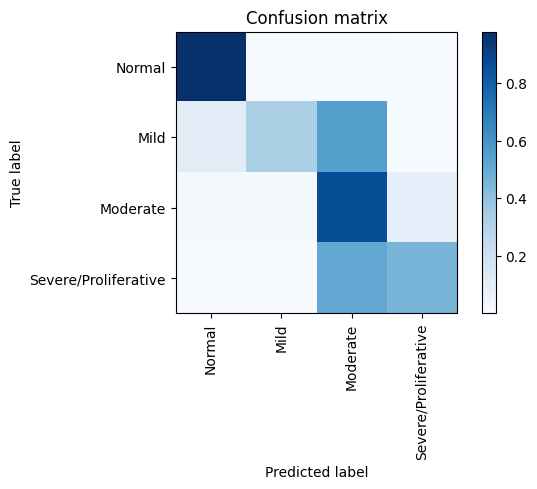

Confusion Matrix AFTER PHASE 1
[[0.98 0.01 0.01 0.  ]
 [0.11 0.33 0.55 0.01]
 [0.02 0.02 0.87 0.09]
 [0.01 0.01 0.52 0.46]]
Classification Report
                      precision    recall  f1-score   support

              Normal       0.96      0.98      0.97       547
                Mild       0.73      0.33      0.45       125
            Moderate       0.66      0.87      0.75       353
Severe/Proliferative       0.69      0.46      0.55       160

            accuracy                           0.81      1185
           macro avg       0.76      0.66      0.68      1185
        weighted avg       0.81      0.81      0.79      1185

Validation Cohen Kappa score: 0.901


In [21]:
# Xác suất dự đoán cho phase 1 2
# ---- DỰ ĐOÁN ----
validation_predictions_raw = model.predict(
    val_generator,
    steps = val_generator.n // val_generator.batch_size + 1,
    verbose = 1
)

# Lấy class có xác suất cao nhất
validation_predictions = np.argmax(validation_predictions_raw, axis=1)

# ---- GROUND TRUTH ----
validation_truth = val_generator.classes   # nhãn thật

from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score

def plot_confusion_matrix(cm, target_names, title = 'Confusion matrix', cmap = plt.cm.Blues):
    plt.grid(False)
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation = 90)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

np.set_printoptions(precision = 2)
cm = confusion_matrix(validation_truth, validation_predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plot_confusion_matrix(cm = cm, target_names = diag_text)
plt.show()

print('Confusion Matrix AFTER PHASE 1')
print(cm)

print('Classification Report')
print(classification_report(validation_truth, validation_predictions, target_names = diag_text))

print("Validation Cohen Kappa score: %.3f" % cohen_kappa_score(validation_predictions, validation_truth, weights = 'quadratic'))

In [23]:

FINETUNING_EPOCHS = 20
FINETUNING_LEARNING_RATE = 1e-4
model.load_weights("stage1_best_original.h5", by_name=True, skip_mismatch=True)
# Make all layers trainable
for layer in model.layers:
    layer.trainable = True
    
class SoftmaxFocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0, alpha=0.25, name="softmax_focal_loss"):
        super().__init__(name=name)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        """
        y_true: one-hot vector
        y_pred: softmax probabilities (after activation)
        """
        y_pred = tf.clip_by_value(y_pred, 1e-8, 1.0 - 1e-8)  # tránh log(0)

        cross_entropy = -y_true * tf.math.log(y_pred)
        focal_weight = self.alpha * tf.pow(1 - y_pred, self.gamma)

        loss = tf.reduce_sum(focal_weight * cross_entropy, axis=1)
        return tf.reduce_mean(loss)
        
class BinaryFocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0, alpha=0.25, name="binary_focal_loss"):
        super().__init__(name=name)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        """
        y_true: multi-label one-hot (0/1) với sigmoid output
        y_pred: sigmoid probabilities
        """
        y_pred = tf.clip_by_value(y_pred, 1e-8, 1.0 - 1e-8)

        # focal loss từng nhãn
        cross_entropy = - (y_true * tf.math.log(y_pred) + 
                           (1 - y_true) * tf.math.log(1 - y_pred))
        focal_weight = (y_true * self.alpha * tf.pow(1 - y_pred, self.gamma) +
                        (1 - y_true) * (1 - self.alpha) * tf.pow(y_pred, self.gamma))

        loss = focal_weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))

import math
# Compile with lower LR
model.compile(
    optimizer = Adam(learning_rate = FINETUNING_LEARNING_RATE), 
    loss=SoftmaxFocalLoss(gamma=2.0, alpha=0.25),
    metrics = ['accuracy']
)

# Callbacks
checkpoint = ModelCheckpoint(
    'blindness_detector_best.keras',   # ✅ đuôi .keras cho full model
    monitor='val_accuracy',
    save_best_only=True,      
    mode='max',
    verbose=1
)

rlrop = ReduceLROnPlateau(
    monitor = 'val_loss', 
    patience = 3, 
    factor = 0.5, 
    min_lr = 1e-6, 
    verbose = 1
)

stopping = EarlyStopping(
    monitor = 'val_accuracy', 
    patience = 8, 
    restore_best_weights = True, 
        mode='max',  
    verbose = 1
)

# ✅ Fix: Disable multiprocessing for stability on Windows
finetune_history = model.fit(
     train_generator,
    class_weight = class_weights_dict,
    steps_per_epoch = math.ceil(train_generator.n / train_generator.batch_size),
    validation_data = (x_val, y_val),
    epochs = FINETUNING_EPOCHS,
    callbacks = [qwk_cb, rlrop, stopping],         
    verbose = 1
).history
model.save("blindness_detector_best.keras")

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 36s 600ms/step

Epoch 1: val_qwk = 0.8941
297/297 ━━━━━━━━━━━━━━━━━━━━ 438s 720ms/step - accuracy: 0.8526 - loss: 0.0375 - val_accuracy: 0.8380 - val_loss: 0.0403 - learning_rate: 1.0000e-04
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step

Epoch 2: val_qwk = 0.8569
297/297 ━━━━━━━━━━━━━━━━━━━━ 82s 275ms/step - accuracy: 0.8483 - loss: 0.0381 - val_accuracy: 0.8177 - val_loss: 0.0396 - learning_rate: 1.0000e-04
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step

Epoch 3: val_qwk = 0.8784
297/297 ━━━━━━━━━━━━━━━━━━━━ 82s 274ms/step - accuracy: 0.8694 - loss: 0.0293 - val_accuracy: 0.8447 - val_loss: 0.0358 - learning_rate: 1.0000e-04
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step

Epoch 4: val_qwk = 0.8161
297/297 ━━━━━━━━━━━━━━━━━━━━ 81s 273ms/step - accuracy: 0.8763 - loss: 0.0278 - val_accuracy: 0.7696 - val_loss: 0.0606 - learning_rate: 1.0000e-04
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step

Epoch 5: val_qwk = 0.8704
297/297 ━━━━━━━

In [ ]:
training_accuracy = warmup_history['accuracy'] + finetune_history['accuracy']
validation_accuracy = warmup_history['val_accuracy'] + finetune_history['val_accuracy']
training_loss = warmup_history['loss'] + finetune_history['loss']
validation_loss = warmup_history['val_loss'] + finetune_history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(training_accuracy, label = 'Training Accuracy')
plt.plot(validation_accuracy, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(training_loss, label = 'Training Loss')
plt.plot(validation_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# -------------------------------
# 1. Load Phase 2 model
# -------------------------------
# model_cb = tf.keras.models.load_model("blindness_detector_best.keras", compile=False)

# -------------------------------
# 2. CBAM block
# -------------------------------





# -------------------------------
# 3. CB-Focal Loss
# -------------------------------
import tensorflow as tf
import numpy as np

class CBFocalLoss(tf.keras.losses.Loss):
    def __init__(self, beta=0.9999, gamma=2.0, class_counts=None, boost_factors=None, name="cb_focal_loss"):
        """
        beta: hệ số cho class-balanced term (0.9999 hay dùng)
        gamma: hệ số Focal (2.0 thường tốt)
        class_counts: số mẫu của từng lớp (list hoặc np.array)
        boost_factors: list hệ số tăng weight cho từng lớp (vd [1,1,1,1.5,1.5] để tăng recall lớp 3,4)
        """
        super().__init__(name=name)
        self.beta = beta
        self.gamma = gamma

        # Tính weight cho từng lớp theo công thức Class-Balanced
        if class_counts is not None:
            effective_num = 1.0 - np.power(beta, class_counts)
            weights = (1.0 - beta) / np.array(effective_num)
            weights = weights / np.sum(weights) * len(class_counts)  # normalize
        else:
            weights = np.ones(len(class_counts)) if class_counts is not None else None

        # Nhân thêm boost factor nếu có
        if boost_factors is not None and weights is not None:
            weights = weights * np.array(boost_factors)

        self.class_weights = tf.constant(weights, dtype=tf.float32) if weights is not None else None

    def call(self, y_true, y_pred):
        """
        y_true: one-hot vector
        y_pred: softmax probabilities
        """
        y_pred = tf.clip_by_value(y_pred, 1e-8, 1.0 - 1e-8)

        # cross entropy
        ce = -y_true * tf.math.log(y_pred)

        # focal term
        focal_weight = tf.pow(1 - y_pred, self.gamma)

        # class balanced weight
        if self.class_weights is not None:
            class_w = tf.reduce_sum(self.class_weights * y_true, axis=1)  # pick weight theo nhãn thật
            loss = class_w * tf.reduce_sum(focal_weight * ce, axis=1)
        else:
            loss = tf.reduce_sum(focal_weight * ce, axis=1)

        return tf.reduce_mean(loss)





# -------------------------------
# 4. Build Phase 3 model
# -------------------------------
n_classes = 4
class_counts = np.array([1796, 1069, 995, 1062 + 1003])
boost_factors = [1, 1, 1, 1.5]

loss_fn = CBFocalLoss(
    beta=0.9999,
    gamma=2.0,
    class_counts=class_counts,
    boost_factors=boost_factors
)
model.compile(optimizer=Adam(1e-5), loss=loss_fn, metrics=["accuracy"])

# ------------------------------




# 6. Callbacks
# -------------------------------
early_cb = EarlyStopping(monitor="val_accuracy", patience=7, restore_best_weights=True, verbose=1)
ckpt_cb = ModelCheckpoint("blindness_detector_phase3_cbam.keras",
                          monitor="val_accuracy", save_best_only=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# -------------------------------
# 7. Warmup: train head
# -------------------------------
history_head = model.fit(
    train_generator,
    validation_data=(x_val, y_val),
    epochs=3,
    # class_weight = class_weights_dict,
    callbacks=[early_cb, qwk_cb, rlrop],
    verbose=1
)

# -------------------------------
# 8. Unfreeze block cuối ResNet50V2
# -------------------------------


model.compile(optimizer=Adam(5e-6), loss=loss_fn, metrics=["accuracy"])

# -------------------------------
# 9. Fine-tune toàn block cuối
# -------------------------------
history_finetune = model.fit(
    train_generator,
    validation_data=(x_val, y_val),
    epochs=10,
    # class_weight = class_weights_dict,
    callbacks=[early_cb, qwk_cb, rlrop],
    verbose=1
)

# -------------------------------
# 11. Save model Phase 3 + CBAM
# -------------------------------
model.save("blindness_detector_phase3_cb_cbam.keras")


Epoch 1/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 38s 506ms/step

Epoch 1: val_qwk = 0.8515
297/297 ━━━━━━━━━━━━━━━━━━━━ 440s 719ms/step - accuracy: 0.8672 - loss: 0.1289 - val_accuracy: 0.8076 - val_loss: 0.1678 - learning_rate: 1.0000e-05
Epoch 2/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step

Epoch 2: val_qwk = 0.8703
297/297 ━━━━━━━━━━━━━━━━━━━━ 82s 274ms/step - accuracy: 0.8844 - loss: 0.1162 - val_accuracy: 0.8295 - val_loss: 0.1608 - learning_rate: 1.0000e-05
Epoch 3/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step

Epoch 3: val_qwk = 0.8635
297/297 ━━━━━━━━━━━━━━━━━━━━ 81s 272ms/step - accuracy: 0.8826 - loss: 0.1138 - val_accuracy: 0.8228 - val_loss: 0.1640 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 2.
Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 509ms/step

Epoch 1: val_qwk = 0.8589
297/297 ━━━━━━━━━━━━━━━━━━━━ 440s 712ms/step - accuracy: 0.8888 - loss: 0.1081 - val_accuracy: 0.8118 - val_loss: 0.1722 - learning_rate: 5.0000e-06
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━

## Plot learning curves

## Evaluate the model

### Get validation predictions from the final model

### Plot some metrics

In [ ]:
import numpy as np
from sklearn.metrics import cohen_kappa_score
from functools import partial
from scipy.optimize import minimize

# ---- Step 1: Predict raw ----
validation_predictions_raw = model.predict(x_val)   # (N, 5) sigmoid output multi-label
validation_truth = y_val.sum(axis=1) - 1            # ground truth (0-4)

# ---- Step 2: Define decode function ----
def apply_thresholds(preds, thresholds):
    # preds shape (N, 5) -> multi-label DR
    return (preds > thresholds).astype(int).sum(axis=1) - 1

# ---- Step 3: Define metric (QWK) ----
def qwk_loss(thresholds, preds, labels):
    thresholds = np.clip(thresholds, 0.01, 0.99)  # tránh lệch hẳn 0 hoặc 1
    pred_labels = apply_thresholds(preds, thresholds)
    return -cohen_kappa_score(labels, pred_labels, weights="quadratic")  # maximize QWK

# ---- Step 4: Optimize thresholds ----
initial_thresholds = [0.5, 0.5, 0.5, 0.5, 0.5]   # 5 outputs
opt_result = minimize(
    qwk_loss, 
    initial_thresholds, 
    args=(validation_predictions_raw, validation_truth),
    method="Nelder-Mead"
)

best_thresholds = opt_result.x
print("Best thresholds:", best_thresholds)

# ---- Step 5: Apply best thresholds ----
validation_predictions = apply_thresholds(validation_predictions_raw, best_thresholds)

qwk = cohen_kappa_score(validation_truth, validation_predictions, weights="quadratic")
print("QWK with best thresholds:", qwk)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score

def plot_confusion_matrix(cm, target_names, title = 'Confusion matrix', cmap = plt.cm.Blues):
    plt.grid(False)
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation = 90)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

np.set_printoptions(precision = 2)
cm = confusion_matrix(validation_truth, validation_predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plot_confusion_matrix(cm = cm, target_names = diag_text)
plt.show()

print('Confusion Matrix AFTER PHASE 1')
print(cm)

print('Classification Report')
print(classification_report(validation_truth, validation_predictions, target_names = diag_text))

print("Validation Cohen Kappa score: %.3f" % cohen_kappa_score(validation_predictions, validation_truth, weights = 'quadratic'))

## Look at some predictions from the validation set

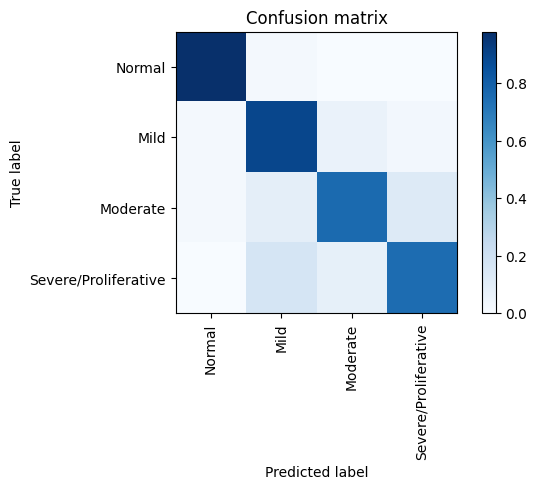

Confusion Matrix AFTER PHASE 2
[[0.98 0.02 0.   0.  ]
 [0.02 0.89 0.06 0.02]
 [0.02 0.09 0.76 0.13]
 [0.   0.16 0.08 0.75]]
Classification Report
                      precision    recall  f1-score   support

              Normal       0.98      0.98      0.98       361
                Mild       0.65      0.89      0.75       201
            Moderate       0.75      0.76      0.75       191
Severe/Proliferative       0.92      0.75      0.82       432

            accuracy                           0.84      1185
           macro avg       0.82      0.84      0.83      1185
        weighted avg       0.86      0.84      0.85      1185

Validation Cohen Kappa score: 0.878


In [25]:
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score

def plot_confusion_matrix(cm, target_names, title = 'Confusion matrix', cmap = plt.cm.Blues):
    plt.grid(False)
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation = 90)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

np.set_printoptions(precision = 2)
cm = confusion_matrix(validation_truth, validation_predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plot_confusion_matrix(cm = cm, target_names = diag_text)
plt.show()

print('Confusion Matrix AFTER PHASE 2')
print(cm)

print('Classification Report')
print(classification_report(validation_truth, validation_predictions, target_names = diag_text))

print("Validation Cohen Kappa score: %.3f" % cohen_kappa_score(validation_predictions, validation_truth, weights = 'quadratic'))

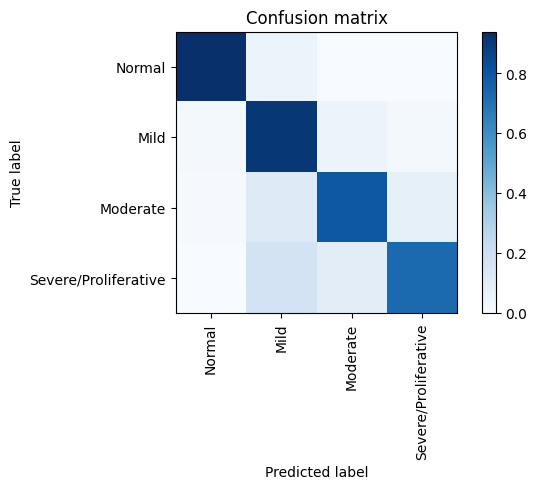

Confusion Matrix AFTER PHASE 3
[[0.94 0.06 0.   0.  ]
 [0.01 0.91 0.05 0.02]
 [0.01 0.12 0.8  0.08]
 [0.   0.17 0.1  0.73]]
Classification Report
                      precision    recall  f1-score   support

              Normal       0.98      0.94      0.96       361
                Mild       0.61      0.91      0.73       201
            Moderate       0.74      0.80      0.77       191
Severe/Proliferative       0.94      0.73      0.82       432

            accuracy                           0.83      1185
           macro avg       0.82      0.84      0.82      1185
        weighted avg       0.87      0.83      0.84      1185

Validation Cohen Kappa score: 0.873


In [30]:
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score

def plot_confusion_matrix(cm, target_names, title = 'Confusion matrix', cmap = plt.cm.Blues):
    plt.grid(False)
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation = 90)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

np.set_printoptions(precision = 2)
cm = confusion_matrix(validation_truth, validation_predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plot_confusion_matrix(cm = cm, target_names = diag_text)
plt.show()

print('Confusion Matrix AFTER PHASE 3')
print(cm)

print('Classification Report')
print(classification_report(validation_truth, validation_predictions, target_names = diag_text))

print("Validation Cohen Kappa score: %.3f" % cohen_kappa_score(validation_predictions, validation_truth, weights = 'quadratic'))

In [ ]:
def plot_image(prediction_array, predicted_label, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap = plt.cm.binary)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel("{} {:2.0f}% ({})".format(diag_text[predicted_label], 100 * np.max(prediction_array), diag_text[true_label]), color = color)

def plot_prediction(prediction_array, predicted_label, true_label):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(5), prediction_array, color = "#777777")
    plt.ylim([0, 1]) 
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')
  
# Plot some validation images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
plt.figure(figsize=(24, 6))
num_cols = 4
num_rows = 4
for i in range(num_rows * num_cols):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(validation_predictions_raw[i], validation_predictions[i], validation_truth[i], x_val[i])
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_prediction(validation_predictions_raw[i], validation_predictions[i], validation_truth[i])
plt.show() 

## Make some predictions 

### Preprocess the test images

In [ ]:
x_train = None
x_val = None
print("Preprocessing test images...")
!mkdir 'test_images_preprocessed/'
for i, image_id in enumerate(tqdm(test_df['id_code'])):
    image = preprocess_image(f'../input/aptos2019-blindness-detection/test_images/{image_id}')    
    cv2.imwrite(f'./test_images_preprocessed/{image_id}', image)
    

In [ ]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    directory = "./test_images_preprocessed/",
    x_col = "id_code",
    target_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size = 1,
    shuffle = False,
    class_mode = None)

y_test = model.predict_generator(test_generator) > 0.5
y_test = y_test.astype(int).sum(axis = 1) - 1

### Check out the class distribution in the predicitons compared to the traing data

In [ ]:
unique, counts = np.unique(y_test, return_counts = True)
plt.bar(unique, counts)

unique, counts = np.unique(validation_truth, return_counts = True)
plt.bar(unique, counts)

plt.title('Class Frequency Training and Predictions')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [ ]:
## COMPLETED